# Installing required modules

In [1]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [2]:
!pip install torch_pruning==0.2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing required modules

In [3]:
# Importing required modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import models,transforms,datasets
import torch.nn.utils.prune as prune
from copy import deepcopy
import torch_pruning as tp
import sys
import os

# Module to time everything
%load_ext autotime

time: 379 µs (started: 2022-12-04 21:57:00 +00:00)


In [4]:
# Setting up GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

time: 859 ms (started: 2022-12-04 21:57:00 +00:00)


# Import CIFAR-100 and Resize

In [5]:
# Transforming the CIFAR100 train dataset and test dataset
train_transform = transforms.Compose([transforms.Resize(64),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

test_transform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

time: 1.92 ms (started: 2022-12-04 21:57:01 +00:00)


In [6]:
# Loading the train dataset
train_data_set = datasets.CIFAR100(root = "CIFAR100", train = True, download = True, transform = train_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting CIFAR100/cifar-100-python.tar.gz to CIFAR100
time: 7.15 s (started: 2022-12-04 21:57:01 +00:00)


In [7]:
# Loading the test dataset
test_data_set = datasets.CIFAR100(root = "CIFAR100", train = False, download = True, transform = test_transform)

Files already downloaded and verified
time: 1.27 s (started: 2022-12-04 21:57:08 +00:00)


In [8]:
train_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 129 ms (started: 2022-12-04 21:57:09 +00:00)


In [9]:
test_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 5.51 ms (started: 2022-12-04 21:57:09 +00:00)


# VGG16

In [10]:
# Defining number of classes in the dataset
n_classes = 100

# Defining the Batch size for training
batch_size = 64

# Defining Number of epochs
n_epochs = 15

time: 647 µs (started: 2022-12-04 21:57:09 +00:00)


In [11]:
# Importing VGG16 model with 130 million+ parameters
vgg16_model = models.vgg16(pretrained = True)

# Modifying last layer out classes
vgg16_model.classifier[6].out_features = n_classes

vgg16_model = vgg16_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

time: 12.3 s (started: 2022-12-04 21:57:09 +00:00)


In [12]:
# Printing VGG16 Model
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training

In [13]:
# To compute the cross entropy loss between input and target
criterion = nn.CrossEntropyLoss()

# To implement stochastic gradient descent and optimize the model
sgd_optimizer = optim.SGD(vgg16_model.parameters(), lr = 0.003, momentum = 0.9)

# Decays the learning rate of each parameter group by gamma every step_size epochs
lr_scheduler = optim.lr_scheduler.StepLR(sgd_optimizer, step_size = 15, gamma = 0.1)

# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader  = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader   = DataLoader(test_data_set, batch_size = batch_size, shuffle = True)

time: 1.43 ms (started: 2022-12-04 21:57:22 +00:00)


In [14]:
# Method to train the model
def fit(model, dataset, optimizer, scheduler, criterion):
  # Set model to training mode
  model.train()
  if scheduler != None:
    scheduler.step()
  # Iterating over the data
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    # Reset the gradients
    optimizer.zero_grad()
    # Generate predictions
    pred  = model(data)
    # Calculate loss
    loss  = criterion(pred, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()

time: 1.13 ms (started: 2022-12-04 21:57:22 +00:00)


In [15]:
from os import pread
# Method to validate the model
def validate(model, dataset, criterion):
  # Set model to evaluation mode
  model.eval()
  accuracy  = 0
  loss      = []
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    pred    = model(data)
    # Get loss
    l = criterion(pred, targets)
    loss.append(l.item())
    # Get index of class label
    _,preds = torch.max(pred.data,1)
    # Get accuracy
    accuracy += torch.sum(preds == targets).item()

  return 100*accuracy/len(dataset.dataset), np.mean(np.array(loss))

time: 2.16 ms (started: 2022-12-04 21:57:22 +00:00)


In [16]:
train_loss  = []
train_acc   = []
test_loss   = []
test_acc    = []
epochs      = []
epoch_value = 0

# Loop for n_epochs
for epoch in range(n_epochs):
  # Fit model
  fit(vgg16_model, train_dataloader, sgd_optimizer, lr_scheduler, criterion)

  # Train validation
  train_accuracy, train_lss = validate(vgg16_model, train_dataloader, criterion)
  train_loss.append(train_lss)
  train_acc.append(train_accuracy)

  # Test validation
  test_accuracy, test_lss = validate(vgg16_model, test_dataloader, criterion)
  test_loss.append(test_lss)
  test_acc.append(test_accuracy)

  # Printing the epochs with Traing Loss, Train Accuracy, Test Loss and Test Accuracy
  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{train_loss[-1]:.4f}\t Train_Acc:{train_acc[-1]:.4f}\t Test_Loss:{test_loss[-1]:.4f}\t Test_Acc:{test_acc[-1]:.4f}')
  epoch_value +=1
  epochs.append(epoch_value)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1	 Train_Loss:2.9770	 Train_Acc:22.0240	 Test_Loss:2.9720	 Test_Acc:21.9200
Epoch: 2	 Train_Loss:1.8516	 Train_Acc:47.3980	 Test_Loss:1.8768	 Test_Acc:47.0600
Epoch: 3	 Train_Loss:1.4252	 Train_Acc:58.9860	 Test_Loss:1.5182	 Test_Acc:56.8100
Epoch: 4	 Train_Loss:1.2389	 Train_Acc:63.9740	 Test_Loss:1.3961	 Test_Acc:60.3300
Epoch: 5	 Train_Loss:1.0360	 Train_Acc:69.6760	 Test_Loss:1.2841	 Test_Acc:63.5000
Epoch: 6	 Train_Loss:0.9114	 Train_Acc:72.8280	 Test_Loss:1.2117	 Test_Acc:65.2600
Epoch: 7	 Train_Loss:0.8016	 Train_Acc:75.7900	 Test_Loss:1.1886	 Test_Acc:67.6400
Epoch: 8	 Train_Loss:0.7126	 Train_Acc:78.6220	 Test_Loss:1.1381	 Test_Acc:68.6000
Epoch: 9	 Train_Loss:0.5975	 Train_Acc:81.8160	 Test_Loss:1.0938	 Test_Acc:70.1500
Epoch:10	 Train_Loss:0.6247	 Train_Acc:81.2260	 Test_Loss:1.1470	 Test_Acc:69.4100
Epoch:11	 Train_Loss:0.5420	 Train_Acc:83.3800	 Test_Loss:1.1296	 Test_Acc:69.7300
Epoch:12	 Train_Loss:0.4602	 Train_Acc:85.8640	 Test_Loss:1.1297	 Test_Acc:70.6000
Epoc

Test Loss:  [2.9719934919077877, 1.876826244554702, 1.5182372787196166, 1.3960511805904898, 1.2841327573843062, 1.2117138829580538, 1.1886329434479876, 1.1381115871629897, 1.0938001757214784, 1.147048495757352, 1.1296309126410515, 1.1296615365204539, 1.2001943516123825, 1.1601214359520347, 1.0747624791351853]
Epochs:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Test Loss')

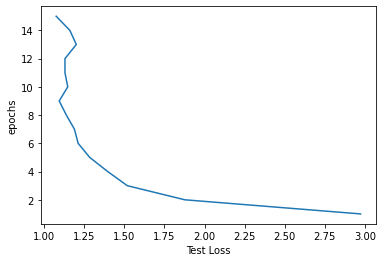

time: 182 ms (started: 2022-12-04 22:34:16 +00:00)


In [17]:
# Plotting Epoch vs Test Loss
print('Test Loss: ', test_loss)
print('Epochs: ', epochs)

plt.plot(test_loss, epochs)
plt.ylabel('epochs')
plt.xlabel('Test Loss')

# Save VGG16 Model

In [18]:
# Authorizing Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 18min 46s (started: 2022-12-04 22:34:17 +00:00)


In [19]:
# Saving the model to Drive
path = F"/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0"
torch.save(vgg16_model.state_dict(), path)

time: 8.5 s (started: 2022-12-04 22:53:03 +00:00)


In [20]:
# Checking the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda
time: 673 µs (started: 2022-12-04 22:53:11 +00:00)


# Important Functions

In [21]:
# Method to remove parameters
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
    return model

time: 1.14 ms (started: 2022-12-04 22:53:11 +00:00)


In [22]:
# Method for Unstructured Pruning
def unstructured_global_pruning(model, amount):
  pruning_model       = deepcopy(model)
  pruning_model       = pruning_model.to(device)
  parameters_to_prune = []
  for module_name, module in pruning_model.named_modules():
      if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))

  prune.global_unstructured(
      parameters = parameters_to_prune,
      pruning_method = prune.L1Unstructured,
      amount = amount)

  pruning_model = remove_parameters(model = pruning_model)

  return pruning_model

time: 1.07 ms (started: 2022-12-04 22:53:11 +00:00)


In [23]:
# Method for Structured Pruning
def structured_pruning(model, sparsity_layer):
  pruning_model         = deepcopy(model)
  pruning_model         = pruning_model.to(device)
  prunable_module_type  = (nn.Conv2d, nn.Linear)
  prunable_modules      = [ m for m in pruning_model.modules() if isinstance(m, prunable_module_type) ]
  strategy              = tp.strategy.L1Strategy()
  Dependency_Graph      = tp.DependencyGraph().build_dependency(pruning_model, example_inputs = torch.randn(1,3,64,64))

  i = 0
  for layer_to_prune in prunable_modules:
    if isinstance(layer_to_prune, nn.Conv2d):
        prune_function = tp.prune_conv
    elif isinstance(layer_to_prune, nn.Linear):
        prune_function = tp.prune_linear
    
    pruning_idxs  = strategy(layer_to_prune.weight, amount = sparsity_layer[i])
    plan          = Dependency_Graph.get_pruning_plan( layer_to_prune, prune_function, pruning_idxs)

    i += 1

    plan.exec()
  
  return pruning_model

time: 1.77 ms (started: 2022-12-04 22:53:11 +00:00)


In [24]:
# Method to evaluate the loss and accuracy of the model
def evaluate(model, dataloader):
  model.eval()
  acc = 0
  loss = []
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)
    out = model(data)
    #Get loss
    l = criterion(out, targets)
    loss.append(l.item())
    #Get index of class label
    _,preds = torch.max(out.data,1)
    #Get accuracy
    acc += torch.sum(preds == targets).item()

  return 100*acc/len(dataloader.dataset), np.mean(np.array(loss))

time: 2.14 ms (started: 2022-12-04 22:53:11 +00:00)


In [25]:
# Method to measure module sparsity
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    n_zeros = 0
    n_elements = 0
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()
            if "bias" in param_name and bias == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 2.67 ms (started: 2022-12-04 22:53:11 +00:00)


In [26]:
# Method to measure Global sparsity
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    n_zeros = 0
    n_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 2.21 ms (started: 2022-12-04 22:53:11 +00:00)


In [27]:
# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data_set, batch_size = batch_size)

time: 1.49 ms (started: 2022-12-04 22:53:12 +00:00)


# Import Model to be Pruned

In [28]:
vgg16_model = models.vgg16(pretrained = False)
vgg16_model.classifier[6].out_features = n_classes

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


time: 2.02 s (started: 2022-12-04 22:53:12 +00:00)


In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 960 ms (started: 2022-12-04 22:53:14 +00:00)


In [30]:
vgg16_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0'))

<All keys matched successfully>

time: 984 ms (started: 2022-12-04 22:53:15 +00:00)


In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

time: 141 ms (started: 2022-12-04 22:53:16 +00:00)


In [32]:
next(vgg16_model.parameters()).is_cuda

True

time: 7.55 ms (started: 2022-12-04 22:53:16 +00:00)


In [33]:
# Measuring Global Sparsity for VGG16 Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            vgg16_model,
            weight=True,
            bias=False,
            conv2d_use_mask=False,
            linear_use_mask=False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.00
time: 18.9 ms (started: 2022-12-04 22:53:16 +00:00)


# Iterative Pruning Iteration

# Unstructured Pruning

In [34]:
ustp_model = unstructured_global_pruning(vgg16_model, 0.8)

time: 374 ms (started: 2022-12-04 22:53:16 +00:00)


In [35]:
next(ustp_model.parameters()).is_cuda

True

time: 6.86 ms (started: 2022-12-04 22:53:16 +00:00)


In [36]:
acc, loss = evaluate(ustp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  73.29 	Loss :  1.1272888870755577
time: 9.88 s (started: 2022-12-04 22:53:16 +00:00)


In [37]:
# Measuring Global Sparsity for Unstructured Pruning Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            ustp_model,
            weight  = True,
            bias    = False,
            conv2d_use_mask = False,
            linear_use_mask = False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.80
time: 15.7 ms (started: 2022-12-04 22:53:26 +00:00)


In [38]:
# Measuring Sparsity for each layer
sparsity_layer = []
i = 0
layer = []
for module_name, module in ustp_model.named_modules():
  if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
    num_zeros, num_elements, sparsity = measure_module_sparsity(module, weight=True, bias=False, use_mask=False)
    print('Layer', i , num_zeros, num_elements, sparsity)
    sparsity_layer.append(sparsity)
    layer.append(i)
    i+= 1

Layer 0 68 1728 0.03935185185185185
Layer 1 5993 36864 0.1625705295138889
Layer 2 12479 73728 0.1692572699652778
Layer 3 28822 147456 0.1954616970486111
Layer 4 67642 294912 0.2293633355034722
Layer 5 163890 589824 0.277862548828125
Layer 6 159437 589824 0.2703128390842014
Layer 7 373889 1179648 0.31694963243272567
Layer 8 929452 2359296 0.3939531114366319
Layer 9 937448 2359296 0.3973422580295139
Layer 10 899120 2359296 0.3810967339409722
Layer 11 908280 2359296 0.384979248046875
Layer 12 996838 2359296 0.42251502143012154
Layer 13 93586310 102760448 0.9107230634105449
Layer 14 10154797 16777216 0.6052730679512024
Layer 15 1450837 4096000 0.354208251953125
time: 53.7 ms (started: 2022-12-04 22:53:26 +00:00)


Sparsity:  [0.03935185185185185, 0.1625705295138889, 0.1692572699652778, 0.1954616970486111, 0.2293633355034722, 0.277862548828125, 0.2703128390842014, 0.31694963243272567, 0.3939531114366319, 0.3973422580295139, 0.3810967339409722, 0.384979248046875, 0.42251502143012154, 0.9107230634105449, 0.6052730679512024, 0.354208251953125]
Layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Sparsity')

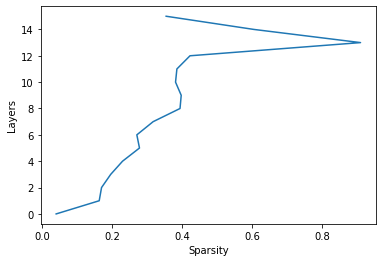

time: 151 ms (started: 2022-12-04 22:53:26 +00:00)


In [39]:
# Plotting Sparsity vs Layers
print('Sparsity: ', sparsity_layer)
print('Layers: ', layer)

plt.plot(sparsity_layer, layer)
plt.ylabel('Layers')
plt.xlabel('Sparsity')

In [40]:
sparsity_layer = [ max(round(round(i,2)-0.01,2),0) for i in sparsity_layer]
sparsity_layer

[0.03,
 0.15,
 0.16,
 0.19,
 0.22,
 0.27,
 0.26,
 0.31,
 0.38,
 0.39,
 0.37,
 0.37,
 0.41,
 0.9,
 0.6,
 0.34]

time: 4.65 ms (started: 2022-12-04 22:53:26 +00:00)


# Structured Pruning

In [41]:
stp_model = structured_pruning(ustp_model, sparsity_layer)

time: 1.21 s (started: 2022-12-04 22:53:26 +00:00)


In [42]:
tp.utils.count_params(stp_model)

13203121

time: 5.33 ms (started: 2022-12-04 22:53:28 +00:00)


In [43]:
stp_model.classifier[6].out_features = 100
print(stp_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(63, 55, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(55, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(108, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(104, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(200, 187, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(187, 190, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
stp_model = stp_model.to(device)
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  6.22 	Loss :  4.476632625434049
time: 6.92 s (started: 2022-12-04 22:53:28 +00:00)


# Fine Tuning

In [ ]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.001, momentum = 0.9)
epochs = 10

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch: 1	 Train_Loss:0.9694	 Train_Acc:71.4100	 Test_Loss:1.2487	 Test_Acc:64.1500
Epoch: 2	 Train_Loss:0.7604	 Train_Acc:77.3440	 Test_Loss:1.1600	 Test_Acc:67.8800
Epoch: 3	 Train_Loss:0.6134	 Train_Acc:81.6720	 Test_Loss:1.0788	 Test_Acc:70.3800
Epoch: 4	 Train_Loss:0.5870	 Train_Acc:82.2180	 Test_Loss:1.1272	 Test_Acc:70.1100
Epoch: 5	 Train_Loss:0.5112	 Train_Acc:84.2400	 Test_Loss:1.1295	 Test_Acc:70.3000
Epoch: 6	 Train_Loss:0.4535	 Train_Acc:85.8360	 Test_Loss:1.1183	 Test_Acc:71.0000
Epoch: 7	 Train_Loss:0.4197	 Train_Acc:86.7700	 Test_Loss:1.1393	 Test_Acc:71.7700
Epoch: 8	 Train_Loss:0.3880	 Train_Acc:87.7800	 Test_Loss:1.1633	 Test_Acc:71.4200


In [ ]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.0001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+11:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

In [ ]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.00001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None , criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+16:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

In [ ]:
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

In [ ]:
torch.save(stp_model, 'pruned_model.pt')

In [ ]:
import sys
sys.getsizeof('pruned_model.pt')

In [ ]:
import os
pruned_model_size = os.path.getsize('pruned_model.pt')
print("Pruned Model Size is :", pruned_model_size/(1024*1024), "mb")

In [ ]:
original_model_size = os.path.getsize('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0')
print("Original VGG16 Model Size is :", original_model_size/(1024*1024), "mb")

In [ ]:
print(stp_model)